In [2]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap_hbb.json') as f:
  pmap = json.load(f)

#del pmap['ggF-powheg']
#del pmap['muondata']
#del pmap['data']

In [4]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [5]:
# Read in files with no selection
indir = "../outfiles/notrigger/chunksize10000_noselection/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum_nosel = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum_nosel['templates'] = out['templates']
            outsum_nosel['sumw'] = out['sumw']
            started += 1
        else:
            outsum_nosel['templates'].add(out['templates'])
            outsum_nosel['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_z.coffea


In [6]:
# Create template out of no selection events
scale_lumi_nosel = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum_nosel['sumw'].items()}
outsum_nosel['templates'].scale(scale_lumi_nosel, 'dataset')

templates_nosel = outsum_nosel['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [7]:
# Read in files with selection
indir = "../outfiles/notrigger/chunksize100000/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum_sel = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum_sel['templates'] = out['templates']
            outsum_sel['sumw'] = out['sumw']
            started += 1
        else:
            outsum_sel['templates'].add(out['templates'])
            outsum_sel['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize100000/2017_dask_data.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_z.coffea


In [8]:
# Create template out of selection events
scale_lumi_sel = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum_sel['sumw'].items()}
outsum_sel['templates'].scale(scale_lumi_sel, 'dataset')

templates_sel = outsum_sel['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

pass
----------------
Sig. sel. eff. for msd > 105 && msd < 145
pass pt > 350: 2.5055003694222564e-05
pass pt > 450: 1.7379378150867327e-05

Punzi signf. x 1000000
pass pt > 350: 0.4265341402385608
pass pt > 450: 0.3674281730609055

fail
----------------
Sig. sel. eff. for msd > 105 && msd < 145
fail pt > 350: 5.716116874423398e-05
fail pt > 450: 3.672740923544268e-05

Punzi signf. x 1000000
fail pt > 350: 0.04048869370438385
fail pt > 450: 0.03269698884532814

both
----------------
Sig. sel. eff. for msd > 105 && msd < 145
both pt > 350: 8.221617243845654e-05
both pt > 450: 5.410678738631001e-05

Punzi signf. x 1000000
both pt > 350: 0.058187102547679705
both pt > 450: 0.04812827111317427



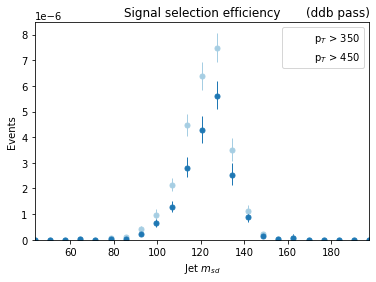

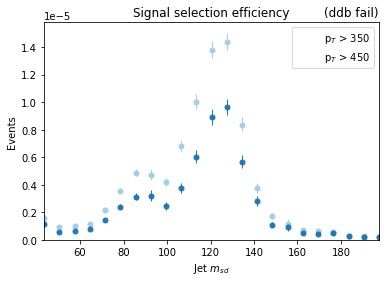

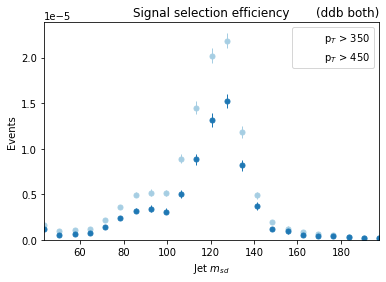

In [10]:
def sig_sel_eff(h):
    eff_mean = np.sum(h.sum('process').values()[()][9:15])
    return eff_mean

# Analysis has maximum sensitivity when punzi significance reaches maximum
def punzi(sig_eff, templates, pt_region, ddb_l, ddb_r, pt_region_2=-1):
    N_bkg = templates['bkg'].integrate('region','signal').sum('genflavor', 'process').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r)).integrate('msd1', slice(105, 145)).values()[()]
    return sig_eff / (1 + np.sqrt(N_bkg))


incl_xsec = {
    'ggF': 4.852E+01,
    'VBF': 3.779E+00,
    'WH': 1.369E+00,
    'ZH':  8.824E-01,
    'ttH': 5.065E-01,
    'tH': 7.370E-02
}

N = np.sum([xsec * lumis[year] * 1000 for _, xsec in incl_xsec.items()])

ddb_regions = ["pass", "fail", "both"]

for ddb_region in ddb_regions:
    if ddb_region == 'pass':
        ddb_l = 0.64
        ddb_r = 1
    elif ddb_region == 'fail':
        ddb_l = 0
        ddb_r = 0.64
    else:
        ddb_l = 0
        ddb_r = 1

    # Histogram of signal with selection (pt > 350)  
    pt_region = 350
    h_sel_pt350 = templates_sel['H(bb)'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    h_sel_pt350.scale(1/N)
    
    # Histogram of signal with selection (pt > 450) 
    pt_region = 450
    h_sel_pt450 = templates_sel['H(bb)'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    h_sel_pt450.scale(1/N)
    
    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }

    fig, ax = plt.subplots(1, 1)
    hist.plot1d(h_sel_pt350,
                overlay="process",
                ax=ax,
                error_opts=data_err_opts)
    
    data_err_opts['color'] = '#1f78b4'
    
    hist.plot1d(h_sel_pt450,
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts)
    
    leg = ax.legend(labels=(r'p$_T$ > 350', r'p$_T$ > 450'))
    ax.set_title('(ddb {0})'.format(ddb_region), loc='right')
    ax.set_title('Signal selection efficiency')

    # Compute signal selection efficiency in signal region (msd > 105 && msd < 145)
    sig_sel_eff_350 = sig_sel_eff(h_sel_pt350)
    sig_sel_eff_450 = sig_sel_eff(h_sel_pt450)
    
    # Compute punzi significance
    punzi_350 = punzi(sig_sel_eff_350, templates_sel, 350, ddb_l, ddb_r)
    punzi_450 = punzi(sig_sel_eff_450, templates_sel, 450, ddb_l, ddb_r)
    
    print(ddb_region + '\n----------------')
    print('Sig. sel. eff. for msd > 105 && msd < 145')
    print('{0} pt > 350: {1}'.format(ddb_region, sig_sel_eff_350))
    print('{0} pt > 450: {1}\n'.format(ddb_region, sig_sel_eff_450))
    print('Punzi signf. x 1000000')
    print('{0} pt > 350: {1}'.format(ddb_region, punzi_350*1000000))
    print('{0} pt > 450: {1}\n'.format(ddb_region, punzi_450*1000000))
    
    fig.savefig('../plots/sig_sel_eff/Hbb_incl_xsec_' + ddb_region + '.png')